In [1]:
import keras
import cv2
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Sequential, Model
from keras import optimizers

Using TensorFlow backend.


In [2]:
def VGG_16(weights_path=None):
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1',input_shape=(150,150,3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    
    #model.add(Flatten(name='flatten'))
    #model.add(Dense(4096, activation='relu', name='fc1'))
    #model.add(Dense(4096, activation='relu', name='fc2'))
    #model.add(Dense(1000, activation='softmax', name='predictions'))
    

    if weights_path:
        model.load_weights(weights_path)

    return model

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
import numpy as np
model_vgg = VGG_16('/home/nishanth/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
model_vgg.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

In [24]:
train_gen = train_datagen.flow_from_directory('/media/nishanth/E/bigdatathings/datascience/projects/data/train',
                                              target_size = (150,150),
                                              batch_size = 64,
                                              class_mode = None,
                                              shuffle = False)


bottleneck_features_train = model_vgg.predict_generator(train_gen, verbose=1)
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)



Found 2129 images belonging to 2 classes.


In [5]:
valid_gen  = train_datagen.flow_from_directory('/media/nishanth/E/bigdatathings/datascience/projects/catVSdogs/test',
                                              target_size = (150,150),
                                              batch_size = 64,
                                              class_mode = None,
                                              shuffle=False)
bottleneck_features_validation = model_vgg.predict_generator(valid_gen, verbose=1)
np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

Found 1600 images belonging to 2 classes.
25/25 [==============================] - 616s 25s/step


In [6]:
print bottleneck_features_validation.shape

(1600, 4, 4, 512)


In [5]:
train_data = np.load(open('bottleneck_features_train.npy'))
train_labels = np.array([0] * 1023 + [1] * 1106)

validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * 800 + [1] * 800)


In [6]:
def FC():
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation = 'sigmoid'))
    return model

In [7]:
model = FC()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(train_data, train_labels,
          epochs=20,
          batch_size=64,
          validation_data=(validation_data, validation_labels))

Train on 2129 samples, validate on 1600 samples
Epoch 1/20
2129/2129 [==============================] - 2s 889us/step - loss: 0.0622 - acc: 0.9756 - val_loss: 0.3793 - val_acc: 0.8862
Epoch 2/20
2129/2129 [==============================] - 2s 840us/step - loss: 0.0305 - acc: 0.9911 - val_loss: 0.4059 - val_acc: 0.8875
Epoch 3/20
2129/2129 [==============================] - 2s 857us/step - loss: 0.0207 - acc: 0.9930 - val_loss: 0.8107 - val_acc: 0.8350
Epoch 4/20
2129/2129 [==============================] - 2s 855us/step - loss: 0.0438 - acc: 0.9798 - val_loss: 0.4257 - val_acc: 0.8938
Epoch 5/20
2129/2129 [==============================] - 2s 868us/step - loss: 0.0338 - acc: 0.9854 - val_loss: 0.4358 - val_acc: 0.9019
Epoch 6/20
2129/2129 [==============================] - 2s 855us/step - loss: 0.0356 - acc: 0.9854 - val_loss: 0.4357 - val_acc: 0.8900
Epoch 7/20
2129/2129 [==============================] - 2s 873us/step - loss: 0.0540 - acc: 0.9854 - val_loss: 0.4484 - val_acc: 0.8925


In [11]:
scores = model.evaluate(validation_data, validation_labels, verbose=1)
print scores

1600/1600 [==============================] - 0s 208us/step
[0.55553967535495763, 0.89812499999999995]


In [12]:
model.save_weights('bottleneck_fc_cats_model.h5')

In [13]:
model.load_weights('bottleneck_fc_cats_model.h5')

In [14]:
model_vgg.add(model)
print model_vgg.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

In [18]:
for layer in model_vgg.layers[:10]:
    layer.trainable = False

In [19]:
model_vgg.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [22]:

train_data = train_datagen.flow_from_directory('/media/nishanth/E/bigdatathings/datascience/projects/data/train',
                                              target_size = (150,150),
                                              batch_size = 16,
                                              class_mode = 'binary')
valid_data = train_datagen.flow_from_directory('/media/nishanth/E/bigdatathings/datascience/projects/catVSdogs/test',
                                              target_size = (150,150),
                                              batch_size = 16,
                                              class_mode = 'binary')

Found 2129 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [23]:
model_vgg.fit_generator(
    train_data,
    epochs=3,
    validation_data=valid_data) 

Epoch 1/3
134/134 [==============================] - 2038s 15s/step - loss: 0.3339 - acc: 0.8885 - val_loss: 0.3371 - val_acc: 0.8894
Epoch 2/3
134/134 [==============================] - 2097s 16s/step - loss: 0.1764 - acc: 0.9375 - val_loss: 0.3573 - val_acc: 0.8594
Epoch 3/3
134/134 [==============================] - 2049s 15s/step - loss: 0.1329 - acc: 0.9557 - val_loss: 0.2284 - val_acc: 0.9125


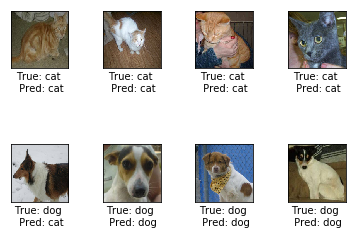

In [25]:
from os import listdir
import matplotlib.pyplot as plt
%matplotlib inline
path = "/media/nishanth/E/bigdatathings/datascience/projects/catVSdogs/valid"
files = [f for f in listdir(path)]
f_labels = np.array(([0] * 4 + [1] * 4)) 
fig,axes = plt.subplots(2,4)
fig.subplots_adjust(hspace=0.6,wspace=0.6)
for n,ax in enumerate(axes.flat):
    img = cv2.imread(path + "/" + files[n])
    img = cv2.resize(img,(150,150))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    if f_labels[n] == 0:
        cls_name = 'cat'
    else:
        cls_name = 'dog'
    pred = model_vgg.predict(img.astype(float).reshape([-1,150,150,3]))
    if pred[0][0] < 0.5:
        pred_name = "cat"
    else:
        pred_name = "dog"
    ax.set_xlabel("True: {0} \n Pred: {1}".format(cls_name,pred_name))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

